**Previous book**: <a href='./01_intro_and_vectorization.ipynb'>[Introduction and Vectorization]</a>

## Part 2: Clustering
**NOTE**: This notebook expects <code>svd_matrix.npy</code> and <code>01_modified_df.csv</code> from the <code>01_intro_and_vectorization.ipynb</code> notebook.

In this part, we will use the reduced TF-IDF vectors from Part 1 to perform k-means clustering. First we will evaluate the optimal number of clusters by taking their silhouette score, and then visualize the clusters using t-SNE.

**Input**: <code>../data/models/svd_matrix.npy</code> and <code>"./data/interrim/01_modified_df.csv</code>

**Output**: <code>../data/interrim/02_clustered_df.csv</code> and <code>../data/models/kmeans_model.pkl</code>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from sklearn.manifold import TSNE

import joblib

svd_matrix = np.load("../data/models/svd_matrix.npy")
full_df = pd.read_csv("../data/interrim/01_modified_df.csv")

## k-means clustering
**k-means clustering** is an unsupervised machine learning technique that attempts to group observations into k distinct clusters. Each observation is assigned to a cluster depending on its distance. Each cluster has a centroid, the prototypical member of that cluster and is calculated as the mean of all observations in that cluster.
### Number of clusters
The number of clusters, k, must be specified beforehand. There are ways to find the optimal number. One such method is by calculating silhouette scores.
#### Silhouette score
The silhouette score is a number calculated for each datapoint between -1 and 1. A datapoint's score corresponds to how well it fits within a cluster. A score of 1 indicates that it is well matched, and a a score -1 indicates that it is in the wrong cluster. A score of zero means that the datapoint is on a boundary between two clusters. The average score across all datapoints can be used to determine how many clusters best fit the data.


In [2]:
ks = range(2,15)
silhouette_scores = []
for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=2, n_init="auto")
    labels = kmeans.fit_predict(svd_matrix)
    score = silhouette_score(svd_matrix, labels)
    silhouette_scores.append(score)

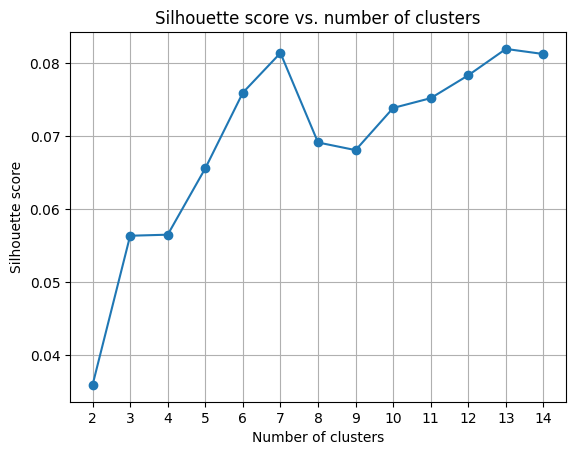

In [3]:
fig, ax = plt.subplots()
    
ax.plot(ks, silhouette_scores, '-o')
ax.set(
        title="Silhouette score vs. number of clusters",
        xlabel="Number of clusters",
        ylabel="Silhouette score",
        xticks=ks
      )
ax.grid()
plt.show()

From the graph above, we can see that <b>7 clusters</b> gives one of the highest silhouette scores (0.081). However, it is worth noting that even the highest silhouette scores are quite close to zero. This suggests that the articles are not easy to group together based on a topic. This is consistent with the dataset being a selection of the featured articles and so are drawn from the full breadth of the encyclopedia. Thirteen clusters actually provides a slightly higher silhouette score (0.082). However, seven clusters is a good compromise between silhouette scores and number of topics.


Continuing with 7 clusters:

In [4]:
kmeans = KMeans(n_clusters=7, random_state=2, n_init="auto")
clusters = kmeans.fit_predict(svd_matrix)

Add the corresponding clusters to the dataframe:

In [5]:
full_df["Cluster"] = clusters
# For brevity, select just titles and Cluster
full_df[["Title", "Cluster"]].head()

,Title,Cluster
0,How to Perform the Tahajjud Prayer,3
1,How to Take a Screenshot on a Windows PC: 8 Si...,5
2,How to Play Poker,0
3,How to French Kiss,3
4,How to Kiss,3


Based on the first five articles, similarly titled articles have been assigned to the same cluster.

For consistency, each cluster should have a consistent colour.

We can add the colour to the data frame too:

In [6]:
cluster_colours = {"Cluster": [0, 1, 2, 3, 4, 5, 6], "Colour": ["#5799C6", "#FE9E4B", "#60B961", "#E05D5E", "#AF8CCC", "#A87F77", "#E992CE"]}
cluster_colours_df = pd.DataFrame.from_dict(cluster_colours)

full_df = full_df.merge(cluster_colours_df, how="left", on="Cluster")

### Initial cluster analysis
How many articles are assigned to each cluster, and is the distribution of articles between the clusters equal?


Examine the number of articles in each cluster.

In [7]:
cluster_numbers = full_df["Cluster"].value_counts().sort_index()
cluster_numbers

Cluster
0    254
1     68
2    241
3    176
4     38
5    135
6     85
Name: count, dtype: int64

As shown above, the articles are not distributed evenly and the sizes of the clusters vary a lot. If the clusters were all equal sizes, we would expect around 142 articles (or 14.29%) in each cluster. Therefore, clusters 0 (25.47%), 2 (24.17%) and 3 (17.65%) are larger than expected and probably probably a broad or multiple topics. Other clusters are smaller. Clusters 1 (6.82%), 4 (3.81%) and 6 (8.54%) are all smaller than expected and probably contain articles about more specific or less represented topics.

    
This information is presented graphically below:

Text(0.5, 1.0, 'Number of articles per cluster')

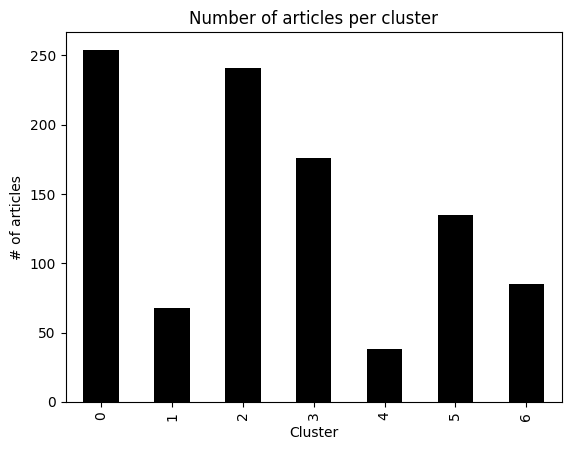

In [8]:
cluster_numbers.plot(kind="bar", color="black")
plt.xlabel("Cluster")
plt.ylabel("# of articles")
plt.title("Number of articles per cluster")

#### Cluster inertia
The inertia of a cluster measures how internally coherent that cluster is by how tightly the data points are around its centroid. A high inertia indicates that the data points within that cluster are spread out resulting in a less compact cluster, whereas low intertia indicates a compact cluster. Inertia is calculated as the square distance between each data point and the centroid of its assigned cluster. For the purposes of k-means clustering, inertia should be minimized.


Total inertia for all the clusters:

In [9]:
round(kmeans.inertia_, 2)

594.16

The total inertia is relatively high. This suggests that the clusters are not very distinct.


What are the inertias scores for each of the clusters found? Do the larger clusters have higher inertia?


Calculate the average inertia for each cluster by summing up the total inertia and dividing by the number of data points in the cluster. The average will allow clusters of different sizes to be compared.

In [10]:
centroids = kmeans.cluster_centers_
inertias_sum = []
inertias_mean = []

for label in range(7):
    cluster_points = svd_matrix[clusters == label]
    inertia_sum = ((cluster_points - centroids[label]) ** 2).sum()
    inertia_mean = inertia_sum / len(cluster_points)
    inertias_sum.append(inertia_sum)
    inertias_mean.append(inertia_mean)

cluster_inertias = {"cluster": range(7), "mean inertia": inertias_mean, "total inertia": inertias_sum, "articles": cluster_numbers}

cluster_df = pd.DataFrame(cluster_inertias).set_index("cluster")
cluster_df.round(2)

,mean inertia,total inertia,articles
cluster,,,
0,0.72,183.00,254
1,0.57,38.97,68
2,0.60,145.50,241
3,0.51,90.31,176
4,0.23,8.74,38
5,0.56,76.10,135
6,0.61,51.53,85


The table displays the mean inertia, total inertia and number of articles in each cluster.

As expected, the clusters with the most inertia also have the most articles. For this reason, the mean inertia is taken. Cluster 4 is both the smallest in size and has the lowest average inertia, suggesting a small relatively compact cluster with a clear topic. On the other hand, the largest cluster, cluster 0, also has the highest average inertia. This suggests that Cluster 0 deals with a broad topic that can include many different articles. The other clusters fall between these two extremes, but a large cluster is not an immediate indication of high average inertia; for example Cluster 3 is large but has one of the lowest average inertias.

### t-SNE
Now that we have a better idea of how the data  clustered, it would be helpful to visualise the clusters in space. However, the dataset has 194 dimension and would be impossible to plot. t-SNE (or t-Distributed Stochastic Neighbor Embedding) is useful in this situation. t-SNE is another dimensionality reduction technique, but is used to visualize high dimensionality data in two or three dimensions rather than as a preprocessing step. t-SNE maps data points from higher dimensionalities to lower dimensions while preserving local distances.

In [11]:
TSNE_model = TSNE(learning_rate="auto", perplexity=50, random_state=2)
TSNE_matrix = TSNE_model.fit_transform(svd_matrix)

The t-SNE transforms the dataset from 194 dimension to 2. This allows the data to be plotted:

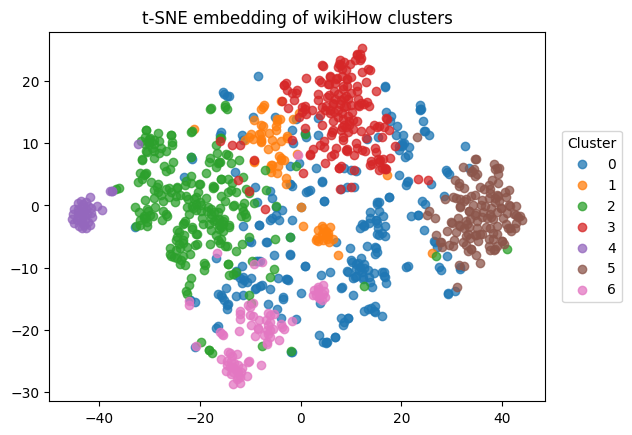

In [12]:
unique_clusters = set(clusters)

fig, ax = plt.subplots()

for cluster in unique_clusters:
    xs = TSNE_matrix[clusters == cluster][:, 0]
    ys = TSNE_matrix[clusters == cluster][:, 1]
    ax.scatter(xs, ys, label=cluster, alpha=0.75)

ax.set(title="t-SNE embedding of wikiHow clusters")
ax.legend(title="Cluster", bbox_to_anchor=(1.02, 0.5), loc='center left')


The above chart shows the t-SNE transformed distribution of the data points and their corresponding cluster. As expected from previous analysis, the clusters are generally poorly defined and many data points from different clusters overlap.


Starting with the best defined clusters to the worst.

We can see that <b>Cluster 4</b> is the most compact and distinct. This is consistent with the fact that this cluster has by far the lowest inertia (0.23). Furthermore, it has very little overlap with other clusters, with Cluster 2 being the exception. This suggests that the vocabulary used for articles in Cluster 4 is specific to a domain, but some terms may be shared with the topic of Cluster 2.

<b>Cluster 5</b> is another relatively well defined cluster, with all the points contained within a region, albeit further spread out than Cluster 4 (inertia: 0.56). Cluster 5 also shows some overlap with other clusters, namely Cluster 0 and Cluster 2. This also suggests that Cluster 5 has a well defined topic.


<b>Cluster 3</b> is also fairly well defined, but has quite a lot of overlap with the neighbouring clusters. This suggests a relatively well defined topic, but one which has shared vocabulary with other topics.


<b>Cluster 1</b> and <b>Cluster 6</b> are quite similar. Cluster 6 appears to be made up of three smaller clusters with a few outliers, and shows a lot of overlap with both cluster 0 and Cluster 2. Cluster 1 on the other hand, seems to be made up of two (or three) smaller clusters and also overlaps with Cluster 0 and Cluster 2 and additionally Cluster 3. However, Cluster 1 and Cluster 6 do not show much overlap suggesting distinct topics. Both of these clusters seem good candidates to be subdivided.


<b>Cluster 2</b> is quite a large, spaced out cluster with data points across the chart. There is, however, an area of densly distributed datapoints making a central smaller cluster.


Finally, <b>Cluster 0</b> is the largest and least well defined cluster. It shows some degree of overlap with every other clusters except Cluster 4. There are a few area of dense data points, but these are also quite spaced out. This indicates that while there might be one central topic for Cluster 0, it also accepts a lot of various articles that do not fit well in other clusters.

### Summary

In this part we:

<ul>
    <li>Used the reduced TF-IDF vector to perform k-means clustering.</li>
    <li>Evaluated the optimal number of clusters by considering their silhouette scores.</li>
    <li>Added a <code>Cluster</code> column to the original dataframe.</li>
    <li>Visualized the distribution of the clusters with t-SNE.</li>
</ul>

Save the dataframe and the cluster model:

In [13]:
full_df.to_csv("../data/interrim/02_clustered_df.csv", index=False)
joblib.dump(kmeans, "../data/models/kmeans_model.pkl")

['../data/models/kmeans_model.pkl']

In the next part, we will use NMF to interpret common themes present in each cluster, and generate word clouds visualize their topics.

### Navigation
**Previous book**: <a href='./01_intro_and_vectorization.ipynb'>[Introduction and Vectorization]</a>

**Next book**: <a href='./03_topic_modelling.ipynb'>[Topic Modelling]</a>